In [1]:
import sys
import urllib.request
import json
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from pyranges import PyRanges
import trgt

One of the TRGTdb queries is `methyl` which returns CpG stats on alleles as well as their average methylation level across samples. Tandem repeats have been implicated to have a role in transcription ([ref](https://pubmed.ncbi.nlm.nih.gov/19478187/#:~:text=Tandem%20repeats%20are%20variable%20elements,by%20affecting%20local%20chromatin%20structure.)), methylation also may have a role in gene expression ([ref](https://www.nature.com/scitable/topicpage/the-role-of-methylation-in-gene-expression-1070/)), and "More than 50% of human genes initiate transcription from CpG dinucleotide-rich regions referred to as CpG islands." ([ref](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2012-13-11-r110)). 

By the end of this tutorial, you will:
- Understand TRGTdb's methylation/CpG query
- Know how to use pyranges to annotate the TRGTdb Loci with reference information
- See interesting patterns with repsect to tandem repeats, CpG islands, methylation levels, and promoters

# The `methyl` query

First we'll open up our `hprc_105.tdb` and run the `methyl` query.

In [2]:
data = trgt.load_tdb("../test_files/databases/hprc_105.tdb/",
                    lfilters=[("chrom", "==", "chr10")]) # Only pull chr10 for speed
# This is equivalent to running `trgt db query methyl hprc_105.tdb`
# on the command line
methyl = trgt.methyl(data)
methyl.head()

,LocusID,allele_number,allele_length,average_methylation,CpG_obs,CpG_exp,CpG_density,GC_pct
0,77193,2,79,NaN,0,1.151899,0.000000,0.253165
1,77193,3,80,NaN,0,1.137500,0.000000,0.250000
2,77194,3,83,176.0,2,1.325301,0.048193,0.253012
3,77194,4,85,167.0,2,1.294118,0.047059,0.247059
4,77196,0,95,159.0,0,2.526316,0.000000,0.336842


The methyl query's output is on a per-Allele basis and has the columns
- LocusID : The allele's locus
- allele_number : The allele number at the locus
- allele_length : The length of the allele
- average_methylation : The average `average_methylation` across all samples in which the allele was observed
- CpG_obs : The number of 'CG' dinucleoties observed in the allele_sequence
- CpG_exp : The expected number of CGs in the allele_sequence calculted as `(c_count * g_count) / len(seq)`
- CpG_density : The CpG density calculated as `obs * 2 / len(seq)`
- GC_pct : The GC% of the sequence calculated as `(c_count + g_count) / len(seq)`

Let's look at the relationship between `CpG_density` and `average_methylation` for our alleles.

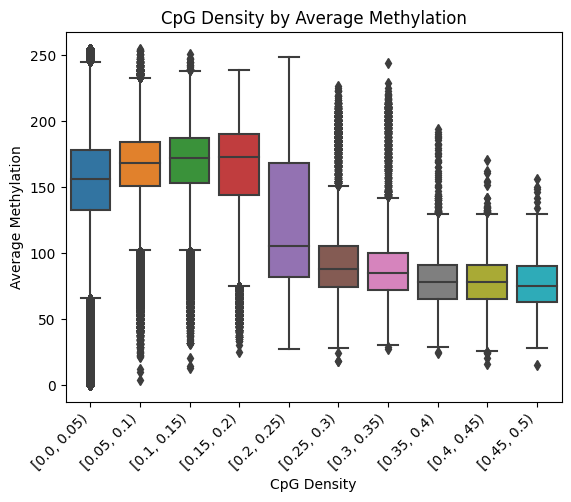

In [3]:
bins = [_ / 100 for _ in range(0, 51, 5)] # Binning to help visualize
methyl['CpGbin'] = pd.cut(methyl['CpG_density'], bins, right=False)
p = sb.boxplot(data=methyl, x="CpGbin", y="average_methylation")
p.set(title="CpG Density by Average Methylation", xlabel="CpG Density", ylabel="Average Methylation")
_ = plt.xticks(rotation=45, ha='right')

The resulting distribution of methylation levels is consistent with the expected human genome methylation profile: CpG denser regions have markedly lower methylation compared to the CpG sparser regions.

# TRs in Promoters and CpG islands

A common operation is to intersect TRGT's analyzed loci with reference annotations. To accomplish this, we'll first need to pull the EPD as our list of promoters [ref](https://academic.oup.com/nar/article/41/D1/D157/1070274?login=false) and as well as the CpG islands track from from UCSC.

In [4]:
url = "https://api.genome.ucsc.edu/getData/track?genome=hg38;track=epdNewPromoter;chrom=chr10"
with urllib.request.urlopen(url) as response:
   html = response.read()
promoters = pd.DataFrame(json.loads(html)['epdNewPromoter'])
promoters.head()

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd
0,chr10,76627,76687,TUBB8_1,900,-,76627,76638
1,chr10,134434,134494,ZMYND11_3,900,+,134483,134494
2,chr10,134750,134810,ZMYND11_2,900,+,134799,134810
3,chr10,135215,135275,ZMYND11_4,900,+,135264,135275
4,chr10,135405,135465,ZMYND11_1,900,+,135454,135465


In [5]:
url = "https://api.genome.ucsc.edu/getData/track?genome=hg38;track=cpgIslandExt;chrom=chr10"
with urllib.request.urlopen(url) as response:
   html = response.read()
known_cpg = pd.DataFrame(json.loads(html)['cpgIslandExt'])
known_cpg.head()

,bin,chrom,chromStart,chromEnd,name,length,cpgNum,gcNum,perCpg,perGc,obsExp
0,585,chr10,11355,12018,CpG: 68,663,68,499,20.5,75.3,0.73
1,585,chr10,48586,49361,CpG: 63,775,63,503,16.3,64.9,0.77
2,585,chr10,73669,74222,CpG: 57,553,57,383,20.6,69.3,0.88
3,585,chr10,76162,76680,CpG: 54,518,54,357,20.8,68.9,0.89
4,586,chr10,134642,136512,CpG: 259,1870,259,1401,27.7,74.9,1.00


Now we'll use PyRanges to find which of the TR loci intersect these annotations. PyRanges expects specific column names for the reference coordinates of ranges, so we'll need to do a `.rename`.

In [6]:
loci = PyRanges(data['locus'].rename(columns={"chrom":"Chromosome",
                                              "start":"Start",
                                              "end":"End"}))
prom = PyRanges(promoters.rename(columns={"chrom":"Chromosome",
                                          "chromStart":"Start",
                                          "chromEnd":"End"}))
cpgs = PyRanges(known_cpg.rename(columns={"chrom":"Chromosome",
                                          "chromStart":"Start",
                                          "chromEnd":"End"}))
# Subset of loci which overlap promoters
prom_subset = loci.overlap(prom)
print(len(prom_subset), "TR loci intersect with promoters")

# Subset of loci which overlap known CpG islands
cpg_subset = loci.overlap(cpgs)
print(len(cpg_subset), "TR loci intersect with known CpG islands")

109 TR loci intersect with promoters
531 TR loci intersect with known CpG islands


Let's annotate our `methyl` summary table with if each allele is inside a locus which intersects a promoter or CpG island and check average_methylation.

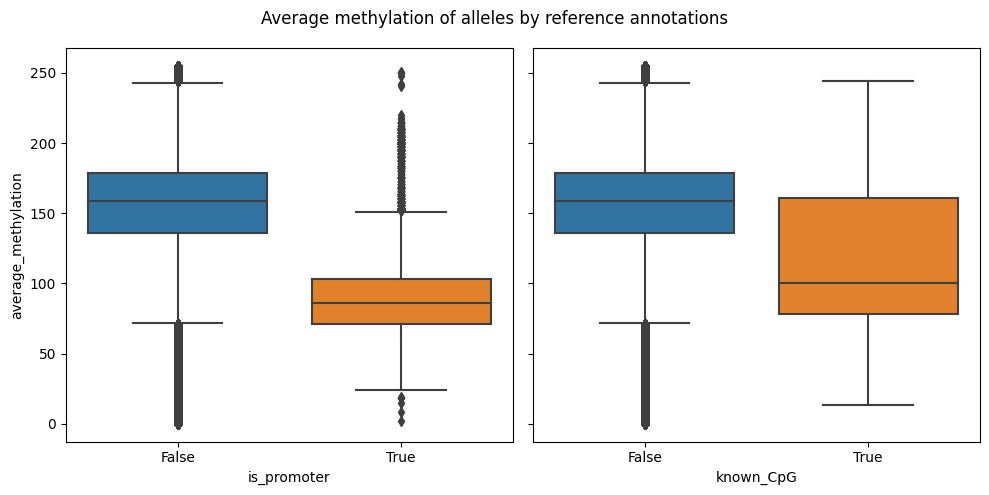

In [7]:
# Note we have to use `subset.df` since subset is a PyRanges object
methyl["is_promoter"] = methyl["LocusID"].isin(prom_subset.df["LocusID"])
methyl["known_CpG"] = methyl["LocusID"].isin(cpg_subset.df["LocusID"])

fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5))
fig.suptitle('Average methylation of alleles by reference annotations')
p1 = sb.boxplot(ax=axes[0], data=methyl, x="is_promoter", y="average_methylation")
p2 = sb.boxplot(ax=axes[1], data=methyl, x="known_CpG", y="average_methylation")
p2.set(ylabel="")
plt.tight_layout()

As expected, the alleles in TRs intersecting promoters or CpG islands have a lower `average_methylation`.

For fun, let's also do a quick test to see if there's a relationship between is_promoter and known CpG_islands. To do this, we'll need to count by Loci. However the methyl query returns a table with a row for each observed allele. Therefore, we'll need to dedup the `methy` table.

In [8]:
import scipy.stats as stats

keys = ["LocusID", "is_promoter", "known_CpG"]
matrix = (methyl.sort_values(keys)
              .drop_duplicates(subset=keys) # Deduplicate alleles per-locus
              .groupby(keys[-2:])
              .size().unstack())

print("Fisher Exact Test ->", stats.fisher_exact(matrix))
matrix

Fisher Exact Test -> SignificanceResult(statistic=443.5904977375566, pvalue=6.981855827433561e-154)


known_CpG,False,True
is_promoter,,
False,44060,442
True,20,89


If we check the distribution of average_methylation of the TR alleles overlapping known_CpG islands, we see a bimodal distribution. The lower peak of the distribution is at least partially explained by CpG island TR alleles overlapping the EPDnew promoters.

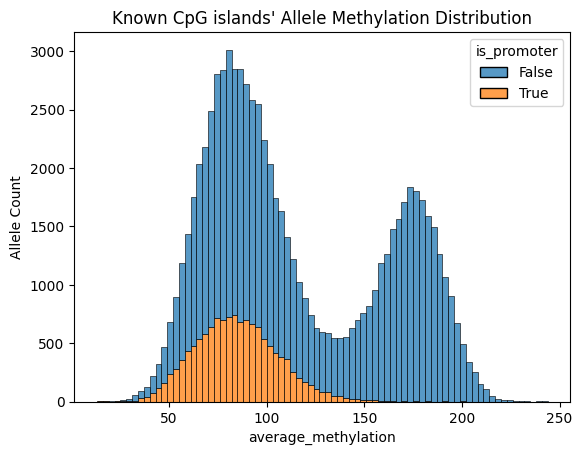

In [9]:
p = sb.histplot(data=methyl[methyl["known_CpG"]].reset_index(),
                x="average_methylation", 
                hue="is_promoter",
                multiple="stack",
                binwidth=3)
_ = p.set(title="Known CpG islands' Allele Methylation Distribution", ylabel="Allele Count")

Conversely, it has been reported that "DNA methylation directly silences genes with non-CpG island promoters" ([ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3196883/])). Checking this subset of alleles reveals some which may be warrant further investigation.

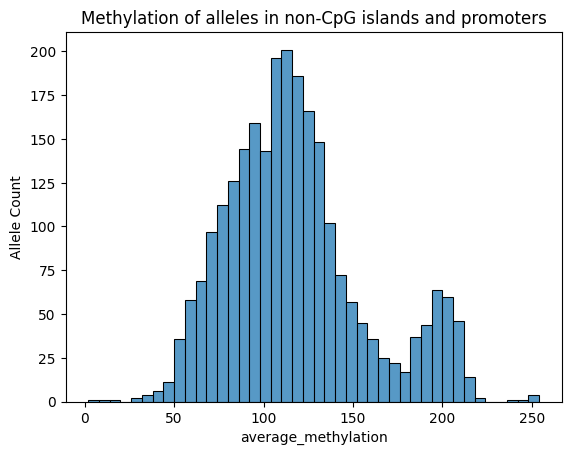

In [10]:
p = sb.histplot(data=methyl[~methyl["known_CpG"] & methyl['is_promoter']].reset_index(),
                x="average_methylation", 
                multiple="stack",
                binwidth=6)
_ = p.set(title="Methylation of alleles in non-CpG islands and promoters", ylabel="Allele Count")